In [ ]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Flatten, Dense, GaussianNoise, Dropout, RandomFlip, RandomRotation, RandomContrast, AveragePooling2D, Conv2D, Concatenate, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model, Sequential, Input
from tensorflow_addons.optimizers import MultiOptimizer
from tensorflow.keras.models import load_model

import os
import random
from joblib import load, dump
import gc
import sys

tf.keras.backend.set_floatx('float32')
input_shape = (128, 128, 3)

In [ ]:
resnet_input =  Input(input_shape)

augment = RandomFlip("horizontal")(resnet_input)
augment = GaussianNoise(0.05)(augment)
augment = RandomRotation(0.2)(augment)
augment = RandomContrast(0.2)(augment)

conv_1 = Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding="valid",strides=2)(augment)


conv_b1_1 = Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding="same")(conv_1)
conv_b1_2 = Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding="same")(conv_b1_1)

sum_1 = Concatenate()([conv_b1_1,conv_b1_2])
avg_1 = AveragePooling2D(pool_size=(2,2))(sum_1)

conv_b2_1 = Conv2D(filters=32,kernel_size=(5,5),activation='relu',padding="same")(avg_1)
conv_b2_2 = Conv2D(filters=32,kernel_size=(5,5),activation='relu',padding="same")(conv_b2_1)

sum_2 = Concatenate()([conv_b2_1,conv_b2_2])
avg_2 = AveragePooling2D(pool_size=(4,4))(sum_2)

conv_b3_1 = Conv2D(filters=16,kernel_size=(3,3),activation='relu',padding="same")(avg_2)
conv_b3_2 = Conv2D(filters=16,kernel_size=(3,3),activation='relu',padding="same")(conv_b3_1)

sum_3 = Concatenate()([conv_b3_1,conv_b3_2])

avg = MaxPooling2D(pool_size=(2,2))(sum_3)
flat = Flatten()(avg)
flat = Dropout(0.2)(flat)

dense2 = Dense(1)(flat)

model = Model(inputs=resnet_input,outputs=dense2)

In [ ]:
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 random_flip_1 (RandomFlip)     (None, 128, 128, 3)  0           ['input_2[0][0]']                
                                                                                                  
 gaussian_noise_1 (GaussianNois  (None, 128, 128, 3)  0          ['random_flip_1[0][0]']          
 e)                                                                                               
                                                                                            

In [ ]:
def mat_shuffle(matrixs):
    widths = np.cumsum([0]+[matrix.shape[1] for matrix in matrixs])
    big = np.hstack(matrixs)
    np.random.shuffle(big)
    return [big[:,widths[i]:widths[i+1]].copy() for i in range(len(matrixs))]

In [ ]:
model = load_model("models/9_model_v3.h5")

In [ ]:
model.compile(optimizer=Adam(1e-3), loss='logcosh')

In [ ]:
results = dict()
c = 0
while True:
    for i in range(2):
        images = load(f"data/{i}_images.joblib")
        ages = load(f"data/{i}_ages.joblib")

        results[f"{c}_{i}"] = model.fit(images, ages[:, None], epochs=64, batch_size=256,
                                        validation_split=0.2, use_multiprocessing=True, verbose=1)
        
        val = (len(ages)*4)//5
        pred = model.predict(images[val:]).flatten()

        plt.scatter(pred, ages[val:], alpha=0.1, lw=0)
        plt.scatter(np.arange(min(pred),max(pred), 0.1),
                    np.arange(min(pred),max(pred), 0.1),
                    color='red', alpha=0.1, lw=0)
        plt.show()
        
        del images
        gc.collect()
        del ages
        gc.collect()
        del pred
        gc.collect()
        
        model.save(f'models/{c}_model_v3.h5')
    c += 1

In [ ]:
images = load(f"data/0_images.joblib")
ages = load(f"data/0_ages.joblib")

In [ ]:
val = (len(ages)*4)//5
pred_train = model.predict(images[:val]).flatten()
pred_test = model.predict(images[val:]).flatten()

In [ ]:
x = np.array((abs(pred_train-ages[:val]).mean(), abs(pred_test-ages[val:]).mean()))

(array([  55.,  452., 3509., 1976., 1034.,  783.,  388.,  206.,   70.,
          12.]), array([ -3.21522522,   8.01197529,  19.2391758 ,  30.46637535,
         41.69357681,  52.92077637,  64.14797974,  75.37517548,
         86.60237885,  97.82957458, 109.05677795]), <BarContainer object of 10 artists>)

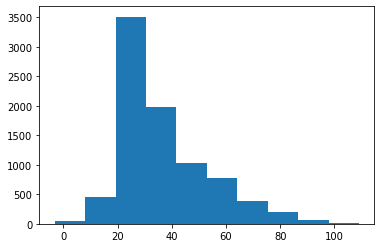

In [ ]:
plt.hist(pred_train*15.54+35.3)

In [ ]:
def predict(url):
    image = tf.image.resize(tf.keras.utils.img_to_array(tf.keras.utils.load_img(url)), input_shape[:2])
    image = (image.numpy().astype('float32')-127.5)/127.5
    image = image[None, ...]
    return float(model.predict(image))*15.54+35.3

In [ ]:
def deprocess(image):
    image = 255*(image + 1.)/2.
    return tf.cast(image, tf.uint8)

In [ ]:
float(model.predict(images[-1][None])*15.54+35.3), ages[-1]*15.54+35.3

array([[25.190775]], dtype=float32)

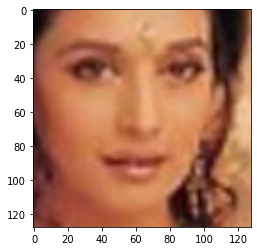

In [ ]:
plt.imshow(im)